In [1]:
%matplotlib inline
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.transforms import t_stick_breaking

/Users/ded/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7201 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:86:00.0)
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import pickle
with open('data/gch-100-10-0.25-5.00.pkl', 'rb') as f:
  GCH = pickle.load(f)
S = 10
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V, type(V)

(16, int)

In [5]:
def get_vmask():
    v_mask = np.zeros([S,S,S])
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            v_mask[s,q]= np.concatenate((c1, c2, c3))
    return tt.constant(v_mask)

In [6]:
def get_imask():
    s_mask = np.zeros([V,S])
    q_mask = np.zeros([V,S])
    for w in np.arange(V):
        f, l = npdata[w, 0] , npdata[w, 1]
        s_mask[w] = np.concatenate((np.ones(f+1), np.zeros(S - f -1)))
        q_mask[w] = np.concatenate((np.zeros(l), np.ones(S-l)))
    i_mask = np.einsum("is,iq->isq", s_mask, q_mask)
    return tt.constant(i_mask)

In [7]:
def get_Risq(a,b):
    tmp_u = npdata[:, 2]
    expanded_u = tmp_u[:, np.newaxis, np.newaxis] *  np.ones((V, S, S)) # V x S x S
    d = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (V, S, S)) # V x S x S
    n = tt.constant(np.clip(d,a_min=0,a_max=S+1))
    n_u = np.triu(d - expanded_u, 0)
    n_u = tt.constant(np.clip(n_u,a_min=0,a_max=max(tmp_u))) # V x S x S
   
    
    # The beta binomial
    R_isq =   tt.gammaln(n+1)
    R_isq -=  tt.gammaln(expanded_u+1)
    R_isq -=  tt.gammaln(n_u+1)   
    R_isq +=  tt.gammaln(expanded_u+a)
    R_isq +=  tt.gammaln(n_u+b)
    R_isq -=  tt.gammaln(n+a+b)
    R_isq +=  tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)

    # The above is the computation of the log, so we take the exponent
    return tt.exp(R_isq)

In [8]:
def get_Risq0(a,b):
    # n = q - s + 1
    n = tt.constant(np.triu(np.ones([S,S]), 0).cumsum(axis =1))
    R0_sq = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    return tt.exp(R0_sq)

In [9]:
def logp_capture(arr, phi, a, b, U, phi_mask, i_mask, R_isq, R0_sq):
    def ll_capture_f(mycaptures):
        
        # Likelihood of Capture Li
        phi_v = tt.pow(1-phi, phi_mask)
        phi_v = tt.prod(phi_v, axis=2)
        LD = arr[:, np.newaxis] * phi_v * phi
        LD_isq = tt.mul(LD, i_mask)
        Li = tt.batched_tensordot(LD_isq, R_isq, axes = 2)
        
        # Likelihood of No-Capture L0
        v0_mask = 1 - phi_mask[0] # tihs is reuse
        LD0 = tt.mul(LD, v0_mask)
        L0 = tt.sum(LD0 * R0_sq)
        
        # Multinomial
        obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0) - tt.gammaln(tt.constant(V)+ 1.0) #
        obj2 = tt.sum(tt.log(Li))
        obj3 = U * tt.log(L0)

        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [10]:
# custom log-liklihood
# model
with pm.Model() as model:
    # parameters
    U = pm.DiscreteUniform('Unseen', lower=V, upper=5*S)
    a = pm.Uniform('alpha', 0., 1.)
    b = pm.Uniform('beta', 2, 10)
    phi    = pm.Uniform('departure', 0., 1., shape=S)
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    
    # Masks: try to compute these once.
    phi_mask = get_vmask()  # S x S x S . all possible arrivals and departures for the "SURVIVAL"
    i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
    R_isq = get_Risq(a, b) #
    R0_sq = get_Risq0(a, b) #
    
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U, phi_mask, i_mask, R_isq, R0_sq), observed=npdata)

In [15]:
with model:
  #posterior = pm.sample(3, tune=0, chains=1, progressbar=False)
  #step = pm.NUTS()
  #posterior = pm.sample(100000, step=step, njobs = 4)
  posterior = pm.sample(10000, cores = 1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [Unseen]
>NUTS: [arrival, departure, beta, alpha]
 49%|████▉     | 5133/10500 [17:22<18:10,  4.92it/s]
There were 862 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


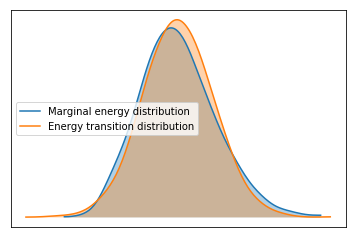

In [16]:
pm.energyplot(posterior);

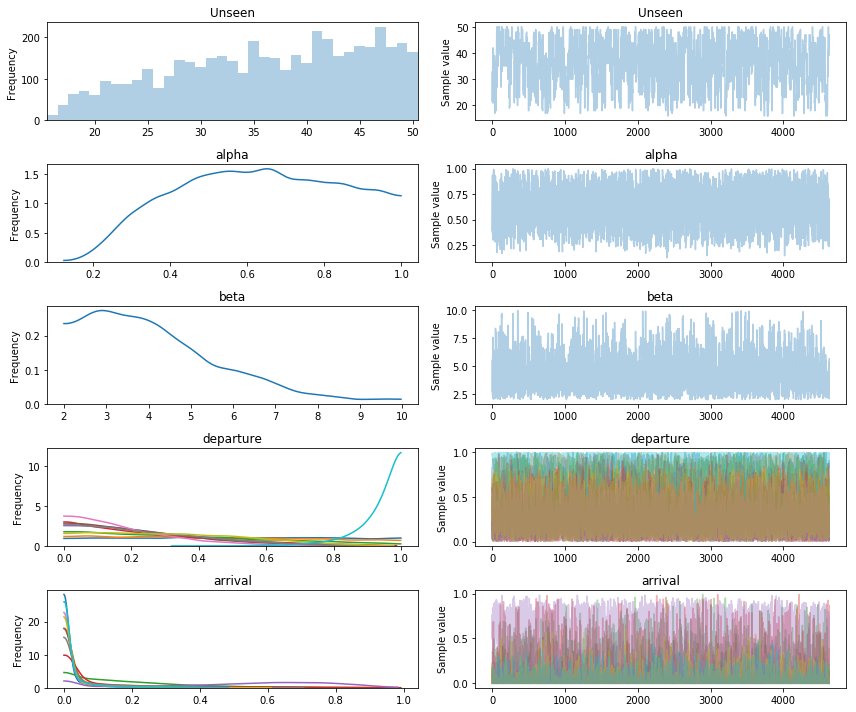

In [17]:
pm.traceplot(posterior);

In [18]:
pm.summary(posterior).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Unseen,36.28,9.12,0.39,20.00,50.00
alpha,0.63,0.21,0.00,0.29,1.00
beta,4.25,1.64,0.04,2.00,7.47
departure__0,0.50,0.29,0.00,0.05,1.00
departure__1,0.45,0.28,0.00,0.01,0.94
departure__2,0.37,0.26,0.00,0.00,0.86
departure__3,0.26,0.22,0.00,0.00,0.71
departure__4,0.24,0.18,0.00,0.00,0.59
departure__5,0.23,0.18,0.00,0.00,0.60
departure__6,0.18,0.15,0.00,0.00,0.49
